In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy import stats
from scipy.fftpack import fft, ifft
import bisect 
from scipy import signal
import pandas as pd
import seaborn as sns
from cdt.metrics import SHD
from cdt.metrics import precision_recall
import time
import random
import heapq
import lingam
import warnings

from helpers import *

warnings.filterwarnings("ignore")

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
T_str='5'
tstop = int(T_str)
numSamples=41
h_window=40
recall_levels = np.linspace(0, 1, 100)
N=5
h=6

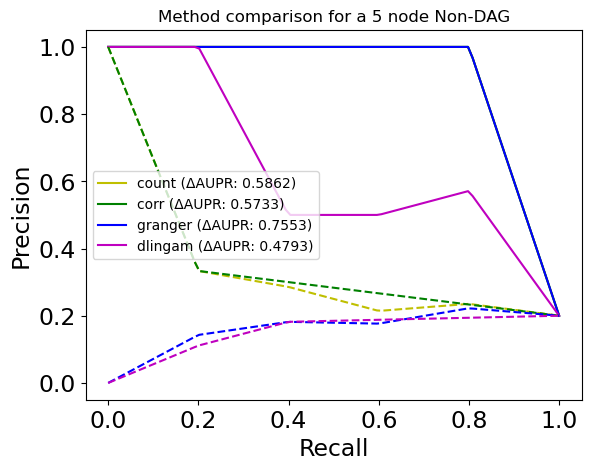

In [3]:
fn1='../data/groundtruth/nondag5node.txt'
gt = getGroundTruth(fn1)

count_matrix, corr_matrix, granger_matrix, dag_matrix = np.zeros((N,N)), np.zeros((N,N)), np.zeros((N,N)), np.zeros((N,N))
count_matrix_ctrl, corr_matrix_ctrl, granger_matrix_ctrl, dag_matrix_ctrl = np.zeros((N,N)), np.zeros((N,N)), np.zeros((N,N)), np.zeros((N,N))
plt.figure()
for i in range(numSamples):
    fn = f'../data/spikedatafromNEURON/nondag5node/rasterplot-5node_{i}.txt'
    numSpikes, spikeTimes = getSpikesInfo(fn)
    randomized_spikes = randomISI(spikeTimes)

    # pre-process data
    binarized_mx = getBinarizedSpikeMatrix(spikeTimes, tstop, N, 1)
    binarized_mx_ctrl = getBinarizedSpikeMatrix(randomized_spikes, tstop, N, 1)
    binned_mx = getBinnedSpikeMatrix(spikeTimes, tstop, N, h_window)
    binned_mx_ctrl = getBinnedSpikeMatrix(randomized_spikes, tstop, N, h_window)

    ##### spike count #####
    count_mx = getSpikeCountMx(h, N, spikeTimes)
    count_mx_ctrl = getSpikeCountMx(h, N, randomized_spikes)
    count_matrix += count_mx
    count_matrix_ctrl += count_mx_ctrl

    ##### cross-corr #####
    C_MX = getCorrDirect(binarized_mx, N, h)
    C_MX_ctrl = getCorrDirect(binarized_mx_ctrl, N, h) 
    corr_matrix += C_MX
    corr_matrix_ctrl += C_MX_ctrl

    ##### granger #####
    output = compute_granger_matrix(binarized_mx, h)
    control = compute_granger_matrix(binarized_mx_ctrl, h)
    granger_matrix += output
    granger_matrix_ctrl += control

    ##### dlingam #####
    model1 = lingam.DirectLiNGAM()
    model1.fit(binned_mx.T)
    model2 = lingam.DirectLiNGAM()
    model2.fit(binned_mx_ctrl.T)
    dag_matrix+=model1.adjacency_matrix_
    dag_matrix_ctrl+=model2.adjacency_matrix_

# spike count
count_mx = count_matrix/numSamples
count_mx_ctrl = count_matrix_ctrl/numSamples

# cross-corr
corr_mx = corr_matrix/numSamples
corr_mx_ctrl = corr_matrix_ctrl/numSamples

# granger
granger_mx = granger_matrix/numSamples
granger_mx_ctrl = granger_matrix_ctrl/numSamples

# dag
dag_pred = dag_matrix/numSamples
dag_pred_ctrl = dag_matrix_ctrl/numSamples

# === Compute PR curves ===
count_curve = compute_smooth_pr(gt, count_mx, recall_levels)
count_curve_ctrl = compute_smooth_pr(gt, count_mx_ctrl, recall_levels)

corr_curve = compute_smooth_pr(gt, corr_mx, recall_levels)
corr_curve_ctrl = compute_smooth_pr(gt, corr_mx_ctrl, recall_levels)

granger_curve = compute_smooth_pr(gt, granger_mx, recall_levels)
granger_curve_ctrl = compute_smooth_pr(gt, granger_mx_ctrl, recall_levels)

dag_curve = compute_smooth_pr(gt, dag_pred, recall_levels)
dag_curve_ctrl = compute_smooth_pr(gt, dag_pred_ctrl, recall_levels)

# === AUPR Scores ===
count_aupr = auc(recall_levels, count_curve)
count_aupr_ctrl = auc(recall_levels, count_curve_ctrl)

corr_aupr = auc(recall_levels, corr_curve)
corr_aupr_ctrl = auc(recall_levels, corr_curve_ctrl)

granger_aupr = auc(recall_levels, granger_curve)
granger_aupr_ctrl = auc(recall_levels, granger_curve_ctrl)

dag_aupr = auc(recall_levels, dag_curve)
dag_aupr_ctrl = auc(recall_levels, dag_curve_ctrl)

# PLOTS
plt.plot(recall_levels, count_curve, "y-", label="count (ΔAUPR: {:.4f})".format(count_aupr - count_aupr_ctrl))
plt.plot(recall_levels, corr_curve, "g-", label="corr (ΔAUPR: {:.4f})".format(corr_aupr - corr_aupr_ctrl))
plt.plot(recall_levels, granger_curve, "b-", label="granger (ΔAUPR: {:.4f})".format(granger_aupr - granger_aupr_ctrl))
plt.plot(recall_levels, dag_curve, "m-", label="dlingam (ΔAUPR: {:.4f})".format(dag_aupr - dag_aupr_ctrl))

plt.plot(recall_levels, count_curve_ctrl, "y--")
plt.plot(recall_levels, corr_curve_ctrl, "g--")
plt.plot(recall_levels, granger_curve_ctrl, "b--")
plt.plot(recall_levels, dag_curve_ctrl, "m--")

plt.title("Method comparison for a 5 node Non-DAG")

plt.xlabel("Recall", fontsize=17)
plt.ylabel("Precision", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend()
plt.show()

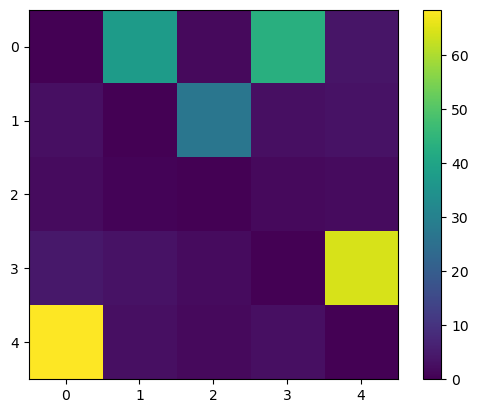

In [4]:
plt.imshow(count_mx)
plt.colorbar()

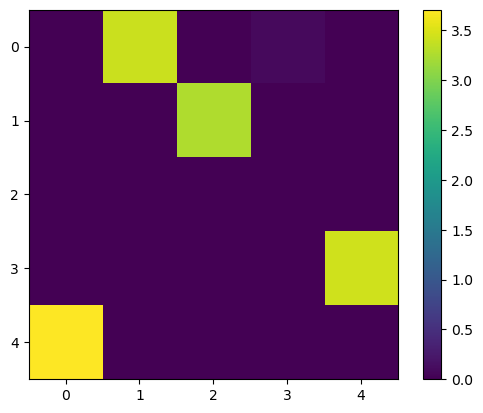

In [5]:
plt.imshow(corr_mx)
plt.colorbar()

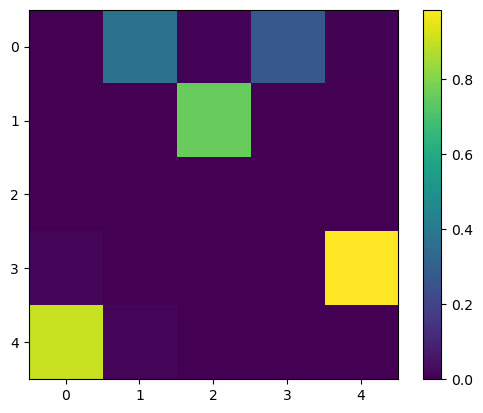

In [6]:
plt.imshow(granger_mx)
plt.colorbar()

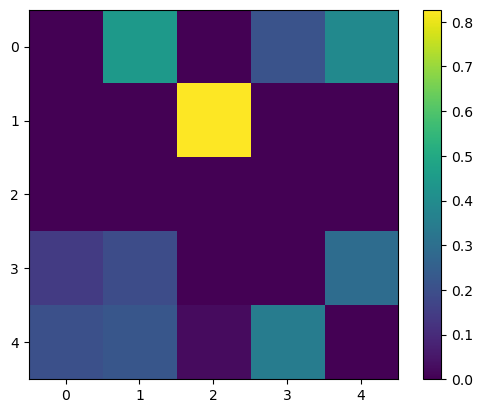

In [7]:
plt.imshow(dag_pred)
plt.colorbar()